In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix

"""A plotting function that displays the training and validation loss and accuracy
   over epochs. It also computes and displays the moving average of these metrics
   to smooth out fluctuations.
   The function is designed to be used as a callback in Keras training loops.
   It uses matplotlib for plotting and IPython's clear_output for dynamic updates.
   The moving average is computed using a simple convolution method.
"""
class LivePlotCallback(tf.keras.callbacks.Callback):
    def __init__(self, window_size=5):
        super().__init__()
        self.history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': [], 'precision': [], 'val_precision': [], 'recall': [], 'val_recall': []}
        self.window_size = window_size  # Moving average window size

    def moving_average(self, data, window_size):
        """Compute a moving average of the input data."""
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

    def on_epoch_end(self, epoch, logs=None):
        # Append the current epoch's logs
        self.history['loss'].append(logs.get('loss'))
        self.history['val_loss'].append(logs.get('val_loss'))
        self.history['accuracy'].append(logs.get('accuracy'))
        self.history['val_accuracy'].append(logs.get('val_accuracy'))
        self.history['precision'].append(logs.get('precision'))
        self.history['val_precision'].append(logs.get('val_precision'))
        self.history['recall'].append(logs.get('recall'))
        self.history['val_recall'].append(logs.get('val_recall'))

        # Clear previous output to update the plot dynamically
        clear_output(wait=True)
        plt.figure(figsize=(15, 10))

        # Plot Loss with moving average
        plt.subplot(2, 2, 1)
        plt.plot(self.history['loss'], label='Training Loss')
        plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.title('Loss Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Plot Accuracy with moving average
        plt.subplot(2, 2, 2)
        plt.plot(self.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Tighten layout and show plot
        plt.tight_layout()
        plt.show()

##############################################################################
# 1) Load and prepare data
##############################################################################
def load_and_prepare_data():
    files = [
        'Classification music/GenreClassData_5s.txt', 
        'Classification music/GenreClassData_10s.txt', 
        'Classification music/GenreClassData_30s.txt'
    ]
    
    train_data_list = []
    test_data_list = []
    datasets = []
    
    # -- Read files and split train/test
    for file in files:
        df = pd.read_csv(file, delimiter='\t')
        df.columns = df.columns.str.strip()  # Remove whitespace from column names
        
        test_df = df[df["Type"] == "Test"]
        train_df = df[df["Type"] == "Train"]
        
        train_labels = train_df["GenreID"].values
        test_labels  = test_df["GenreID"].values
        
        # Drop unnecessary columns
        train_df = train_df.drop(columns=["File", "Genre", "GenreID", "Type","Track ID"])
        test_df  = test_df.drop(columns=["File", "Genre", "GenreID", "Type","Track ID"])
        
        # Store the arrays
        train_data_list.append(train_df.values)
        test_data_list.append(test_df.values)
    
    # -- For each of (train_data_list, test_data_list),
    #    we combine the 5s, 10s, and 30s sets with the right repetition.
    for data_list in [train_data_list, test_data_list]:
        data_5s, data_10s, data_30s = data_list
        
        # Repeat to match sequence length
        data_10s_repeated = np.repeat(data_10s, 2, axis=0)
        data_30s_repeated = np.repeat(data_30s, 6, axis=0)
        
        # Concatenate along the feature dimension
        combined_data = np.concatenate((data_5s, data_10s_repeated, data_30s_repeated), axis=1)
        
        
        # The first pass is for train data, second for test data
        if len(datasets) == 0:
            datasets.append([combined_data, train_labels])
        else:
            datasets.append([combined_data, test_labels])
    
    # datasets[0] = train, datasets[1] = test
    return datasets[0], datasets[1]

##############################################################################
# 2) Load the data
##############################################################################
train, test = load_and_prepare_data()
train_ds, train_labels = train  # train_ds shape => (6*N, num_features)
test_ds,  test_labels  = test   # test_ds shape  => (6*M, num_features)

print("Raw train_ds shape:", train_ds.shape)
print("Raw train_labels shape:", train_labels.shape)
print("Raw test_ds shape:", test_ds.shape)
print("Raw test_labels shape:", test_labels.shape)

##############################################################################
# 3) Reshape data so each group of 6 rows is a single sequence
##############################################################################
N_train = train_labels.shape[0]
N_test  = test_labels.shape[0]

# Check if train_ds has exactly 6*N_train rows
assert train_ds.shape[0] == 6 * N_train, (
    f"train_ds has {train_ds.shape[0]} rows, but we expected {6 * N_train}"
)

# Similarly for test
assert test_ds.shape[0] == 6 * N_test, (
    f"test_ds has {test_ds.shape[0]} rows, but we expected {6 * N_test}"
)

# Number of features (columns) in the flat data
num_features = train_ds.shape[1]

# Reshape to (N, 6, num_features)
train_ds = train_ds.reshape((N_train, 6, num_features))
test_ds  = test_ds.reshape((N_test, 6, num_features))

print("Reshaped train_ds shape:", train_ds.shape)
print("Reshaped test_ds shape:", test_ds.shape)

##############################################################################
# 4) Build tf.data Datasets
##############################################################################
batch_size = 32
global_mean = tf.reduce_mean(train_ds, axis=(0, 1))
global_std = tf.math.reduce_std(train_ds, axis=(0, 1))

tf_train_ds = tf.data.Dataset.from_tensor_slices((train_ds, train_labels))
# Normalize the dataset
def normalize_data(x, y):
    x = tf.cast(x, tf.float64)  # Ensure the feature tensor remains float64
    x = (x - global_mean) / global_std
    y = tf.cast(y, tf.int64)  # Ensure the label tensor remains int64
    return x, y

tf_train_ds = (
    tf_train_ds
    .map(normalize_data)
    .shuffle(buffer_size=700)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)
# Calculate and save the global mean and standard deviation


tf_test_ds = tf.data.Dataset.from_tensor_slices((test_ds, test_labels))
# Create a validation split of 10% from the shuffled train_ds
#val_size = int(0.1 * len(tf_train_ds))
#tf_val_ds = tf_train_ds.take(val_size)
#tf_train_ds = tf_train_ds.skip(val_size)

# Prepare the test dataset
tf_test_ds = (
    tf_test_ds
    .map(normalize_data)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


##############################################################################
# 5) Build and compile the model
##############################################################################

# CNN expects input_shape=(sequence_length, feature_dim), here (6, num_features)
num_classes = len(np.unique(train_labels))
model = Sequential([
    tf.keras.layers.Input(shape=(6, 189, 1)),  # Add channel dimension if missing
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # 10 genres
])




model.summary()

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

Raw train_ds shape: (4752, 189)
Raw train_labels shape: (792,)
Raw test_ds shape: (1188, 189)
Raw test_labels shape: (198,)
Reshaped train_ds shape: (792, 6, 189)
Reshaped test_ds shape: (198, 6, 189)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 6, 189, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 94, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 94, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 47, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3008)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       385,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 405,258 (1.55 MB)

 Trainable params: 405,258 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
for x, y in tf_train_ds.take(1):
    print("x shape:", x.shape)
    print("y shape:", y.shape)
    print(x.numpy()[0][0])
    break

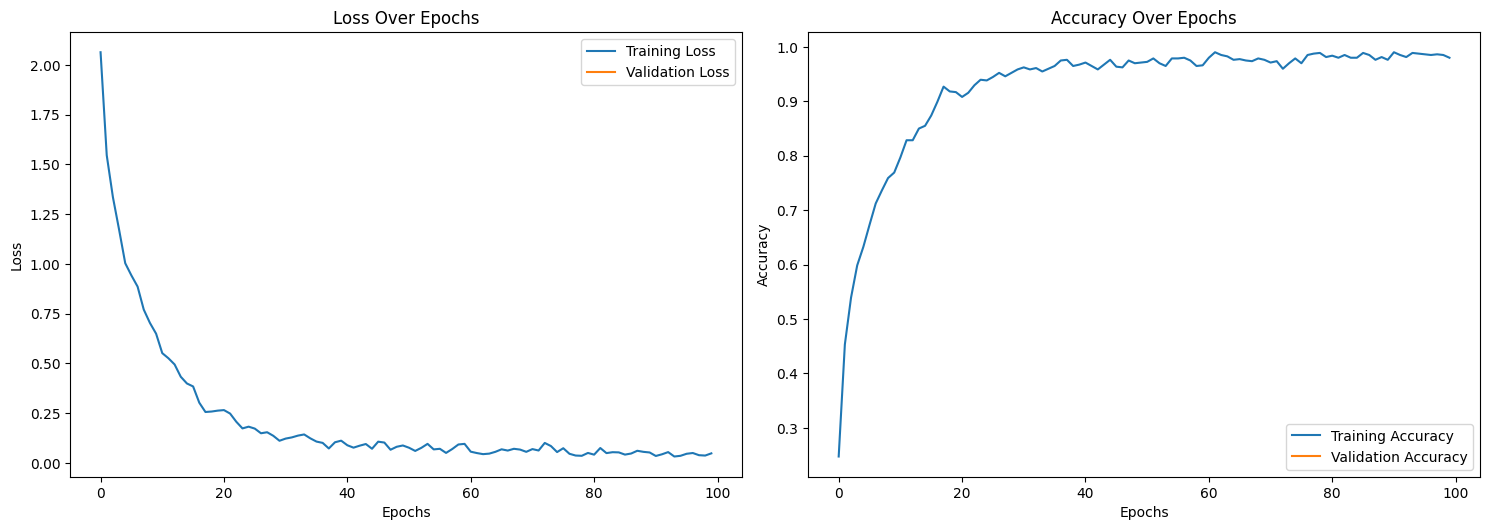

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9791 - loss: 0.0440 - learning_rate: 0.0010
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7668 - loss: 1.5917  


[1.7371551990509033, 0.752525269985199]

In [4]:
##############################################################################
# 6) Train and evaluate
# Validation data is not used in this example, but can be added if needed.
model.fit(tf_train_ds, epochs=100, verbose=1, callbacks=[LivePlotCallback(window_size=5), tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True), tf.keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.5, min_lr=1e-6), tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')]) # validation_data=val_ds,



model.evaluate(tf_test_ds, verbose=1)

In [5]:
model.save('models/MLP_modelv3.keras')

In [ ]:

# Load the best model
best_model = tf.keras.models.load_model('models/MLP_modelv2.keras')
# Evaluate the best model on the test dataset
test_loss, test_accuracy = best_model.evaluate(tf_test_ds, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

y_true = []
y_pred = []

# Iterate over the dataset
for x_batch, y_batch in tf_test_ds:
    # x_batch has shape (batch_size, 6, 186) – keep as is
    predictions = model.predict(x_batch, verbose=0)  # No need to expand dims
    y_true.extend(y_batch.numpy())                  # Append all true labels
    y_pred.extend(np.argmax(predictions, axis=1))   # Get predicted class

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)
model.summary()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7668 - loss: 1.5917  
Test Loss: 1.7372
Test Accuracy: 0.7525
[[15  0  1  0  1  0  0  0  1  2]
 [ 0 19  0  1  0  0  0  0  0  0]
 [ 0  0 11  2  0  0  2  1  2  2]
 [ 0  1  0 18  0  0  1  0  0  0]
 [ 0  0  2  3 13  0  1  1  0  0]
 [ 0  0  0  0  0 19  0  0  0  0]
 [ 1  0  6  4  1  0  6  1  1  0]
 [ 0  0  1  1  0  0  0 18  0  0]
 [ 1  0  1  1  0  0  1  0 14  1]
 [ 0  0  0  1  1  1  1  0  0 16]]


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 6, 189, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 94, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 94, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 47, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3008)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       385,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,215,776 (4.64 MB)

 Trainable params: 405,258 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 810,518 (3.09 MB)